In [1]:
# imports


""""


"""

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from scipy import integrate
from astropy.coordinates import SkyCoord
import os

import astropy.units as u

import astropy.units as u
import matplotlib.pyplot as plt
from mocpy import MOC
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.coordinates import Angle
from mpdaf.obj import Cube
from astropy.coordinates import Angle


from NIRSpec import *

## Damping Parameters from DJA Spectra in MOSAIC Field 

1) Find moc of mosaic field - adjustable depth - input full muse cubes for mosaic  
2) Check redshift ranges for MUSE and DJA
3) Filter sources by moc and z (+vis) - input downloaded spectra from dja - adjustable redshift !Careful what this range is on!
4) Download sources from this filtered sample, filter snr and spectral range and produce table - adjustable SNR, wavelength 
5) Fit UV slopes adnd get parameter(+vis), gets results table 
6) Split sources into damped and not damped - adjustable cut point 
- Find in full table and limit to these filtered samples , save for use later
- The full filtered can also be crossmatched in topcoat with muse detected sources
7) This detected sample can then have parameters fit etc. 

- Can change what redshift range is input to change the size of the sample.
- Can inout hte blind detected sample s- probem is some have hst prior anyway so small sample now


RA range: 53.118964157203955 to 53.20277788893667 degrees
Dec range: -27.824491111100002 to -27.750350732057203 degrees
RA of the four corners: [53.118964157203955, 53.15863281986126, 53.20277788893667, 53.1631122222]
Dec of the four corners: [-27.789317569502852, -27.750350732057203, -27.785511637071558, -27.824491111100002]


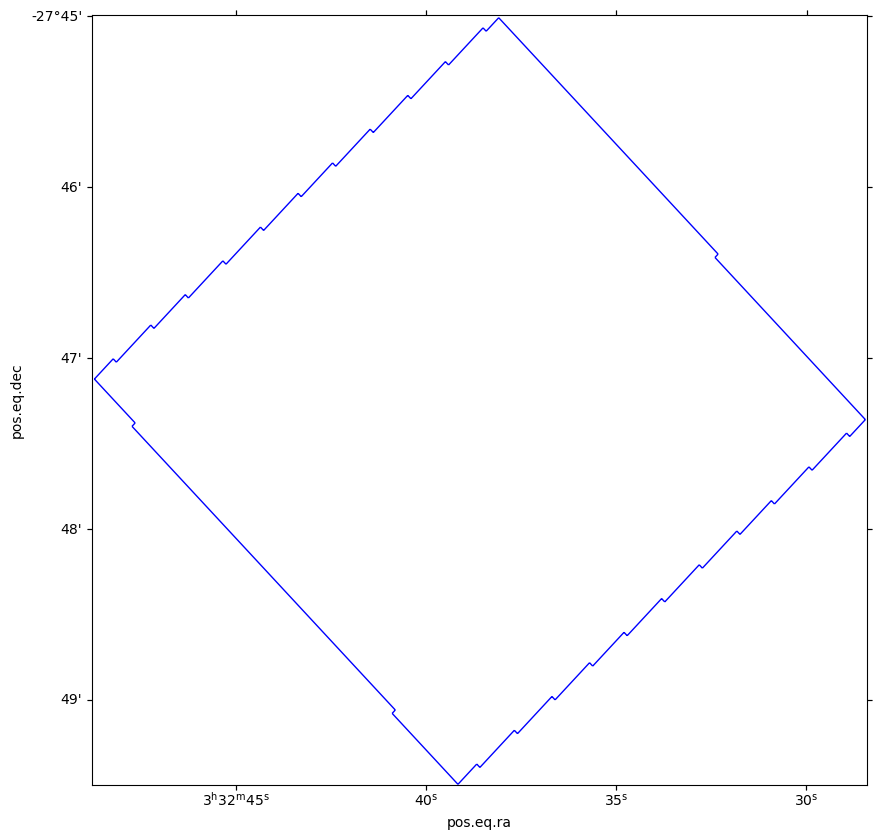

In [2]:
#1

# Get the RA and Dec bounds of the cube and create a MOC from it

cube = Cube('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits')
ra_min, ra_max, dec_min, dec_max, vertices_ra, vertices_dec= get_cube_ra_dec_bounds(cube)
print(f"RA range: {ra_min} to {ra_max} degrees")
print(f"Dec range: {dec_min} to {dec_max} degrees")
print(f"RA of the four corners: {vertices_ra}")
print(f"Dec of the four corners: {vertices_dec}")

# Create a SkyCoord object for the vertices
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)

# Create MOC from polygon
moc = MOC.from_polygon_skycoord(skycoord, max_depth=17) ## changing  depth has big impact


fig = plt.figure(figsize=(10, 10))
wcs = moc.wcs(fig)
ax = fig.add_subplot(projection=wcs)
moc.border(ax, wcs, color='blue')



In [3]:
#2

# This demonstartes the need for the redshift ranges applied below

nirspec = [0.6, 5.3]*u.micron
nirspeca = nirspec.to(u.AA, equivalencies=u.spectral())
Lya = 1215.67*u.AA
z = nirspeca/Lya - 1
print("nirspec range",z)

muse = [4750.0, 9350.0]*u.AA
z_muse = muse/Lya - 1
print("muse range:",z_muse)
lya1 = 1215.67*u.AA*(1 + 5.8)
#print (lya1.to(u.micron))

nirspec range [ 3.93554994 42.59735784]
muse range: [2.90731037 6.691232  ]


Number of sources in CSV: 2565
Number of sources inside MOC: 1539
Filtered sources RA:     ra   
---------
53.162878
53.160634
53.167303
 53.17655
53.154087
53.156129
53.167303
53.166615
 53.17655
53.162381
      ...
 53.17324
53.166129
53.171539
53.163067
 53.17752
53.152613
53.167131
53.154087
53.167726
53.156129
53.159527
Length = 143 rows
Filtered sources Dec:    dec    
----------
-27.769284
-27.771604
 -27.80287
-27.771106
-27.766062
-27.775854
 -27.80287
-27.772395
-27.771106
-27.803325
       ...
-27.795674
-27.772036
 -27.77387
-27.805201
 -27.80252
 -27.79731
-27.794237
-27.766062
-27.768162
-27.775854
-27.771524
Length = 143 rows
Number of filtered sources: 143


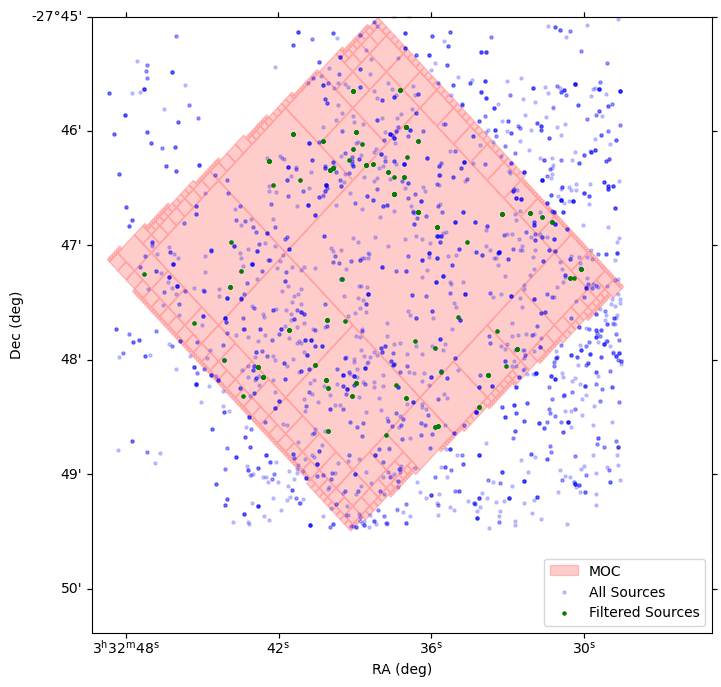

In [4]:
#3

# input dja csv file (bound by ra and dec limits already)
csv_file = '/Users/s2537809/Downloads/mosaic_DJA.csv'  
csv_data = Table.read(csv_file, format='csv')

filtered_sources = filter_sources_in_moc(csv_data, moc, z_min=5.6, z_max=6.6) # -pick range so as not noisy in Nirspec
print(f"Number of filtered sources: {len(filtered_sources)}")

# write the filtered sources to a new csv file
filtered_sources.write('/Users/s2537809/Downloads/mosaic_DJA_filtered.csv', format='csv', overwrite=True)

visualize_moc_and_sources(moc, csv_data, filtered_sources)


In [5]:
#4
set = 'DJA_filtered_56_66'

download_fits_from_DJA('/Users/s2537809/Downloads/mosaic_DJA_filtered.csv', folder_name=set) 

filtered_table = filter_incomplete_spectra(filtered_sources, folder_name=set, min_wavelength=1.0, max_wavelength=4.0,target_wavelength= 1450, SNR_threshold=5.0)
filtered_table.write(f'/Users/s2537809/Downloads/{set}_table.csv', format='csv', overwrite=True)

Processing file 1/143: gds-deep-v3_g140m-f070lp_1210_5447.spec.fits
gds-deep-v3_g140m-f070lp_1210_5447.spec.fits already exists in DJA_filtered_56_66. No need to download.
Processing file 2/143: gds-deep-v3_g140m-f070lp_1210_9880.spec.fits
gds-deep-v3_g140m-f070lp_1210_9880.spec.fits already exists in DJA_filtered_56_66. No need to download.
Processing file 3/143: gds-deep-v3_g235m-f170lp_1210_5113.spec.fits
gds-deep-v3_g235m-f170lp_1210_5113.spec.fits already exists in DJA_filtered_56_66. No need to download.
Processing file 4/143: gds-deep-v3_g235m-f170lp_1210_9414.spec.fits
gds-deep-v3_g235m-f170lp_1210_9414.spec.fits already exists in DJA_filtered_56_66. No need to download.
Processing file 5/143: gds-deep-v3_g235m-f170lp_1210_9842.spec.fits
gds-deep-v3_g235m-f170lp_1210_9842.spec.fits already exists in DJA_filtered_56_66. No need to download.
Processing file 6/143: gds-deep-v3_g235m-f170lp_1210_9867.spec.fits
gds-deep-v3_g235m-f170lp_1210_9867.spec.fits already exists in DJA_filte

In [6]:
filtered_table

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam
str20,int64,int64,float64,float64,str53,str18,int64,int64,str29,int64,float64,float64,str138,str64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64
j033240.15m274810.33,5,7362,53.167303,-27.80287,gds-deep-v3_prism-clear_1210_5113.spec.fits,gds-deep-v3,5113,4,G140M G235M G395H G395M,3,5.8183,5.8183,Redshifts match v2 grade=3,ABu23 z=5.821,1,2.0,0.6,5.29,0.2,32.2,--,41.6,41.82,--,--,--,FITS zfit spl,--,--
j033239.99m274620.62,5,7607,53.166615,-27.772395,gds-deep-v3_prism-clear_1210_8253.spec.fits,gds-deep-v3,8253,4,G140M G235M G395H G395M,3,6.3295,6.3295,Redshifts match v2 grade=3,ABu23 z=6.327,1,3.42,0.6,5.29,-3.6,29.4,--,41.77,42.0,--,--,--,FITS zfit spl,--,--
j033242.37m274615.98,5,7617,53.17655,-27.771106,gds-deep-v3_prism-clear_1210_9414.spec.fits,gds-deep-v3,9414,4,G140M G235M G395H G395M,3,5.8916,5.8916,Redshifts match v2 grade=3,ABu23 z=5.889 ; CSi23 z=N/A ; CSi23 z=N/A ; JWi23 z=5.889,4,2.14,0.6,5.29,11.7,28.2,--,41.83,42.15,--,--,--,FITS zfit spl,--,--
j033242.20m274628.08,1,7939,53.17583,-27.774468,gds-deep-v3_prism-clear_1210_9423.spec.fits,gds-deep-v3,9423,0,--,3,6.3346,6.3346,Redshifts match v2 grade=3,ABu23 z=6.335 ; CSi23 z=N/A,2,4.19,0.6,5.29,-4.1,19.8,--,41.69,41.96,--,--,--,FITS zfit spl,--,--
j033236.98m274557.82,9,7629,53.154087,-27.766062,gds-deep-v3_prism-clear_1210_9842.spec.fits,gds-deep-v3,9842,4,G140M G235M G395H G395M,3,5.8026,5.8026,Redshifts match v2 grade=3,ABu23 z=5.798,1,6.92,0.6,5.29,-3.9,56.1,--,42.25,42.66,--,--,--,FITS zfit spl,--,--
j033237.47m274633.07,9,7632,53.156129,-27.775854,gds-deep-v3_prism-clear_1210_9867.spec.fits,gds-deep-v3,9867,4,G140M G235M G395H G395M,3,6.105,6.105,Redshifts match v2 grade=3,ABu23 z=6.102,1,6.4,0.6,5.29,-4.5,31.3,--,42.01,42.29,--,--,--,FITS zfit spl,--,--
j033238.55m274617.77,5,7634,53.160634,-27.771604,gds-deep-v3_prism-clear_1210_9880.spec.fits,gds-deep-v3,9880,4,G140M G235M G395H G395M,3,5.9804,5.9804,Redshifts match v2 grade=3,JWi23 z=5.974 ; CSi23 z=N/A ; ABu23 z=5.974,3,3.31,0.6,5.29,7.7,37.7,--,41.78,42.09,--,--,--,FITS zfit spl,--,--
j033233.43m274745.12,1,17377,53.139303,-27.795866,gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits,gds-egami-ddt-v3,114613,0,--,3,5.9324,5.9324,Redshifts match v2 grade=3,CSi23 z=N/A,1,4.01,0.6,5.29,-3.4,34.7,--,42.24,42.45,--,--,--,FITS zfit spl,--,--
j033240.04m274814.85,3,10848,53.166853,-27.804125,gds-udeep-v3_prism-clear_3215_201127.spec.fits,gds-udeep-v3,201127,2,G140M G395M,3,5.8353,5.8353,Redshifts match v2 grade=3,CSi23 z=N/A,1,7.83,0.6,5.29,2.1,43.6,--,41.9,42.21,--,--,--,FITS zfit spl,--,--


Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_5113.spec.fits with redshift z = 5.8183
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.36322711
    reduced chi-square = 0.03026893
    Akaike info crit   = -47.1249807
    Bayesian info crit = -45.8468660
    R-squared          = 0.49017587
[[Variables]]
    beta:         -2.01256811 +/- 0.59250796 (29.44%) (init = -1.5)
    log_FUV_1550: -20.5532259 +/- 0.08942082 (0.44%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8542


100%|██████████| 5000/5000 [00:03<00:00, 1482.01it/s]


β_UV: -2.10 with 16-84 percentile range: [-2.10, -2.10]
log_FUV_1550: -2.05e+01 with 16-84 percentile range: [-2.05e+01, -2.05e+01]


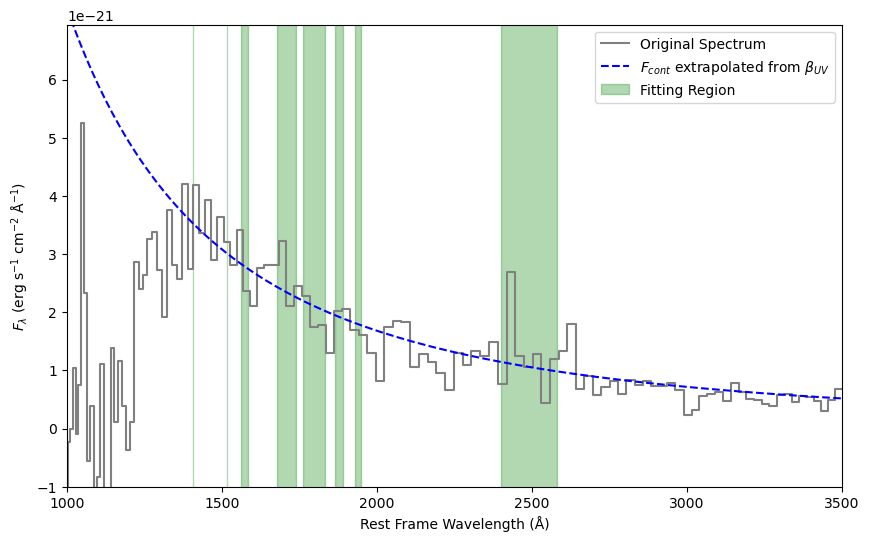

/Users/s2537809/MUSE/NIRSpec.py:327: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  DLyA = simps(integrand, wavelength_LyA)


DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_5113.spec.fits | LyA Damping Parameter (D_LyA): 75.040
Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_8253.spec.fits with redshift z = 6.3295
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.03686705
    reduced chi-square = 0.00283593
    Akaike info crit   = -86.1273094
    Bayesian info crit = -84.7112090
    R-squared          = 0.94589617
[[Variables]]
    beta:         -2.69189703 +/- 0.17855788 (6.63%) (init = -1.5)
    log_FUV_1550: -20.2571175 +/- 0.02654959 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:03<00:00, 1474.09it/s]


β_UV: -2.77 with 16-84 percentile range: [-2.77, -2.77]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


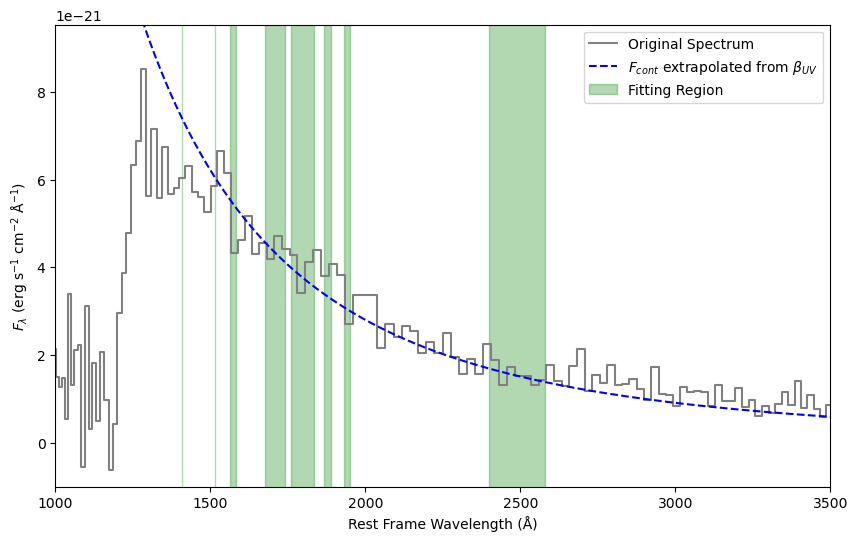

DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_8253.spec.fits | LyA Damping Parameter (D_LyA): 62.364
Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9414.spec.fits with redshift z = 5.8916
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.08733324
    reduced chi-square = 0.00623809
    Akaike info crit   = -79.3698056
    Bayesian info crit = -77.8246282
    R-squared          = 0.89665832
[[Variables]]
    beta:         -2.81828982 +/- 0.25570894 (9.07%) (init = -1.5)
    log_FUV_1550: -20.2289758 +/- 0.03677656 (0.18%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8436


100%|██████████| 5000/5000 [00:03<00:00, 1505.62it/s]


β_UV: -2.86 with 16-84 percentile range: [-2.86, -2.86]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


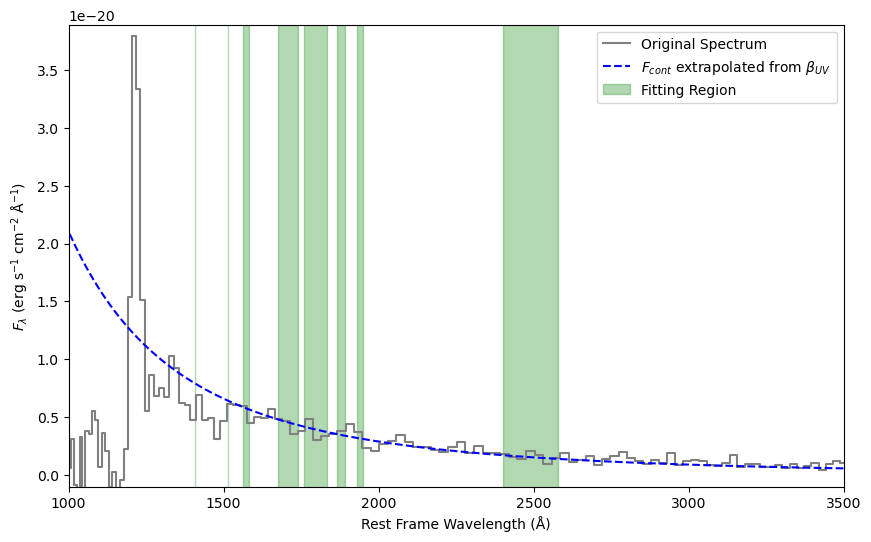

DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9414.spec.fits | LyA Damping Parameter (D_LyA): -31.696
Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9423.spec.fits with redshift z = 6.3346
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.05153988
    reduced chi-square = 0.00396461
    Akaike info crit   = -81.1017428
    Bayesian info crit = -79.6856424
    R-squared          = 0.90414742
[[Variables]]
    beta:         -2.33787319 +/- 0.21112105 (9.03%) (init = -1.5)
    log_FUV_1550: -20.4056717 +/- 0.03133683 (0.15%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8549


100%|██████████| 5000/5000 [00:03<00:00, 1495.26it/s]


β_UV: -2.32 with 16-84 percentile range: [-2.32, -2.32]
log_FUV_1550: -2.04e+01 with 16-84 percentile range: [-2.04e+01, -2.04e+01]


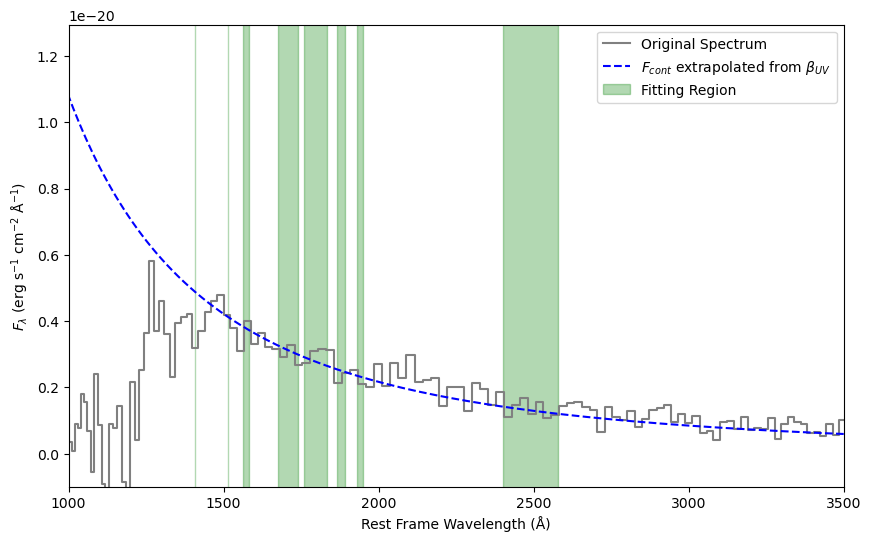

DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9423.spec.fits | LyA Damping Parameter (D_LyA): 66.595
Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9842.spec.fits with redshift z = 5.8026
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01114879
    reduced chi-square = 9.2907e-04
    Akaike info crit   = -95.8967392
    Bayesian info crit = -94.6186246
    R-squared          = 0.96562955
[[Variables]]
    beta:         -2.08110650 +/- 0.11334203 (5.45%) (init = -1.5)
    log_FUV_1550: -19.8869120 +/- 0.01744241 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8842


100%|██████████| 5000/5000 [00:03<00:00, 1508.30it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


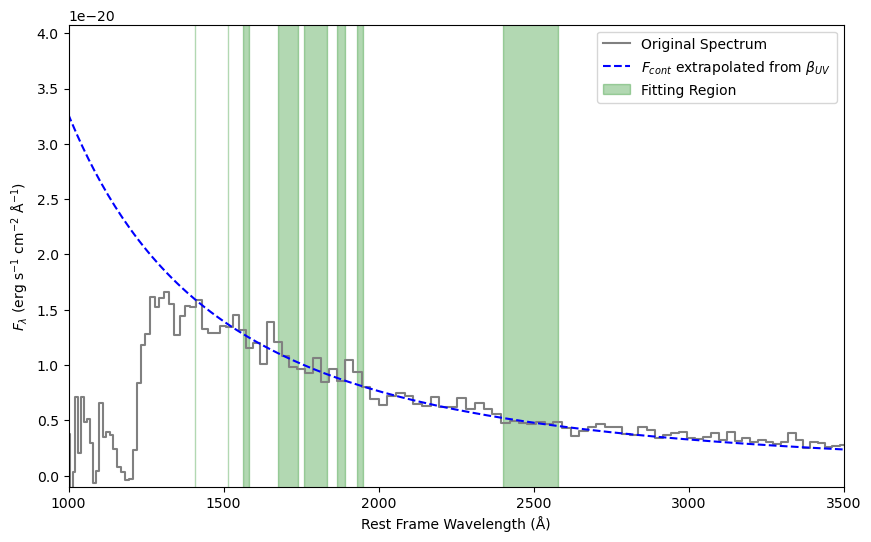

DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9842.spec.fits | LyA Damping Parameter (D_LyA): 65.985
Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9867.spec.fits with redshift z = 6.105
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.02539093
    reduced chi-square = 0.00211591
    Akaike info crit   = -84.3738856
    Bayesian info crit = -83.0957710
    R-squared          = 0.88891739
[[Variables]]
    beta:         -1.53049896 +/- 0.15618336 (10.20%) (init = -1.5)
    log_FUV_1550: -20.0045300 +/- 0.02370828 (0.12%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8551


100%|██████████| 5000/5000 [00:03<00:00, 1493.67it/s]


β_UV: -1.54 with 16-84 percentile range: [-1.54, -1.54]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


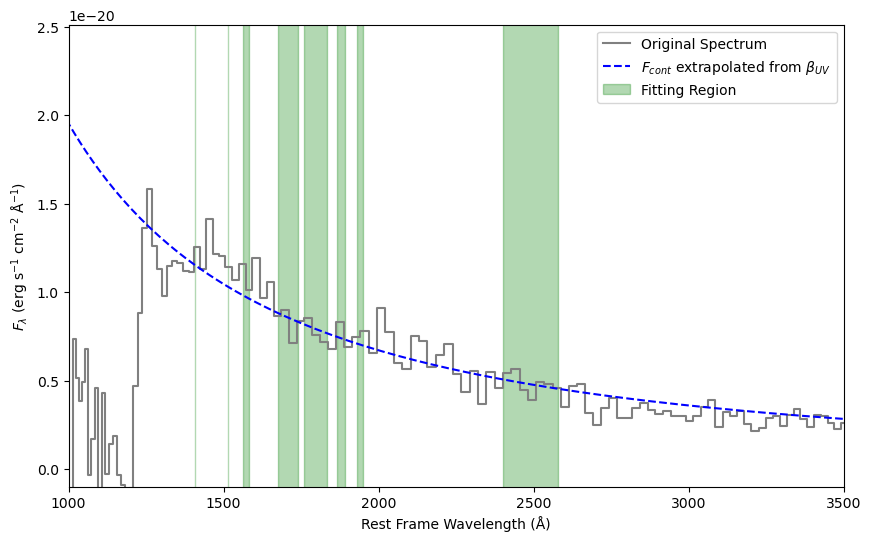

DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9867.spec.fits | LyA Damping Parameter (D_LyA): 44.908
Processing DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9880.spec.fits with redshift z = 5.9804
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.05599159
    reduced chi-square = 0.00399940
    Akaike info crit   = -86.4822798
    Bayesian info crit = -84.9371023
    R-squared          = 0.90901763
[[Variables]]
    beta:         -2.44236862 +/- 0.20650932 (8.46%) (init = -1.5)
    log_FUV_1550: -20.2379187 +/- 0.02962742 (0.15%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8457


100%|██████████| 5000/5000 [00:03<00:00, 1478.96it/s]


β_UV: -2.41 with 16-84 percentile range: [-2.41, -2.41]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


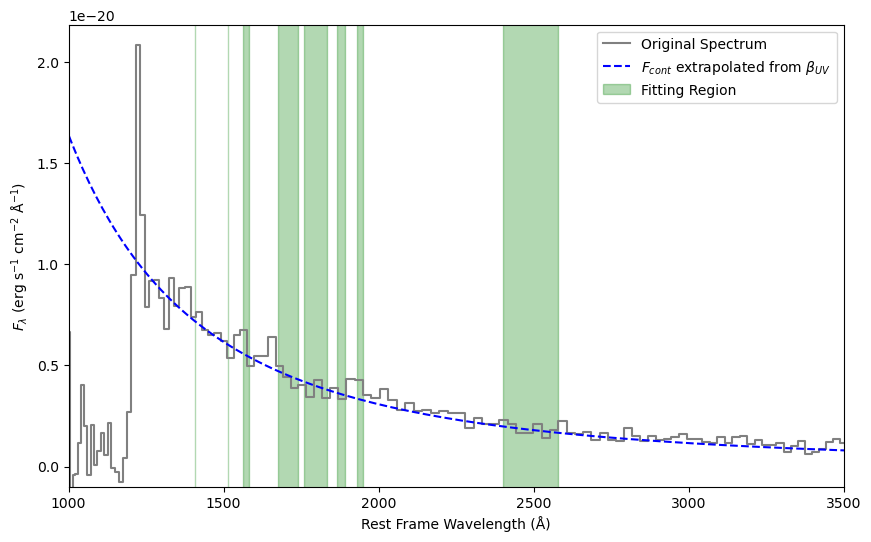

DJA_filtered_56_66/gds-deep-v3_prism-clear_1210_9880.spec.fits | LyA Damping Parameter (D_LyA): 0.928
Processing DJA_filtered_56_66/gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits with redshift z = 5.9324
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.03607084
    reduced chi-square = 0.00300590
    Akaike info crit   = -79.4585883
    Bayesian info crit = -78.1804737
    R-squared          = 0.92872072
[[Variables]]
    beta:         -2.40483516 +/- 0.19232413 (8.00%) (init = -1.5)
    log_FUV_1550: -19.8194057 +/- 0.02747887 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8460


100%|██████████| 5000/5000 [00:03<00:00, 1509.13it/s]


β_UV: -2.42 with 16-84 percentile range: [-2.42, -2.42]
log_FUV_1550: -1.98e+01 with 16-84 percentile range: [-1.98e+01, -1.98e+01]


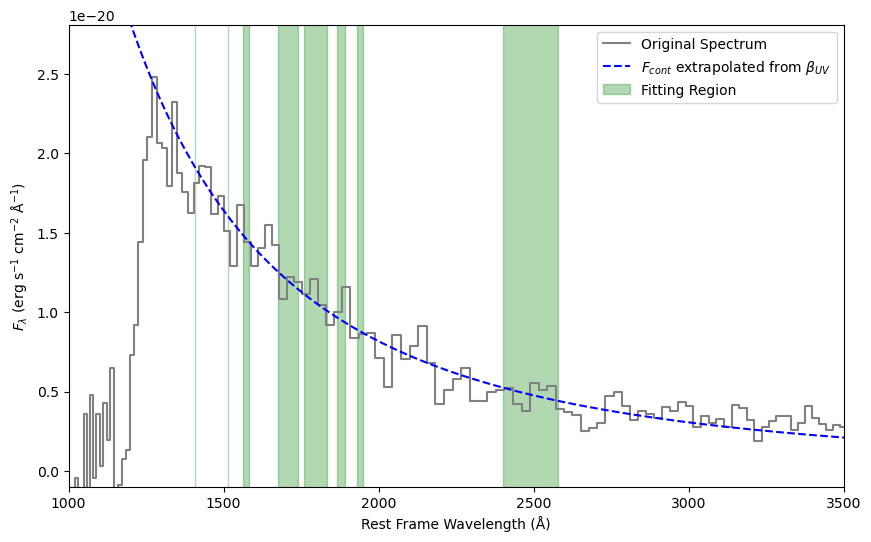

DJA_filtered_56_66/gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits | LyA Damping Parameter (D_LyA): 45.278
Processing DJA_filtered_56_66/gds-udeep-v3_prism-clear_3215_201127.spec.fits with redshift z = 5.8353
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01694847
    reduced chi-square = 0.00141237
    Akaike info crit   = -90.0328916
    Bayesian info crit = -88.7547769
    R-squared          = 0.93556487
[[Variables]]
    beta:         -1.72565902 +/- 0.13073406 (7.58%) (init = -1.5)
    log_FUV_1550: -20.1583330 +/- 0.01878332 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8450


100%|██████████| 5000/5000 [00:03<00:00, 1481.09it/s]


β_UV: -1.75 with 16-84 percentile range: [-1.75, -1.75]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


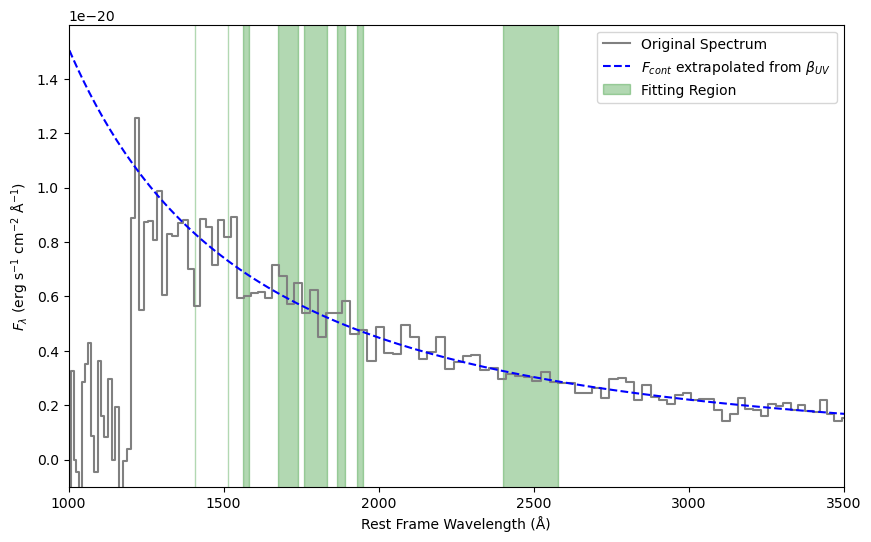

DJA_filtered_56_66/gds-udeep-v3_prism-clear_3215_201127.spec.fits | LyA Damping Parameter (D_LyA): 40.745
Processing DJA_filtered_56_66/gds-udeep-v3_prism-clear_3215_201850.spec.fits with redshift z = 6.0705
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.10320091
    reduced chi-square = 0.00793853
    Akaike info crit   = -70.6869167
    Bayesian info crit = -69.2708163
    R-squared          = 0.76116740
[[Variables]]
    beta:         -1.94333178 +/- 0.30191312 (15.54%) (init = -1.5)
    log_FUV_1550: -20.5420362 +/- 0.04208304 (0.20%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8374


100%|██████████| 5000/5000 [00:03<00:00, 1493.79it/s]


β_UV: -1.90 with 16-84 percentile range: [-1.90, -1.90]
log_FUV_1550: -2.05e+01 with 16-84 percentile range: [-2.05e+01, -2.05e+01]


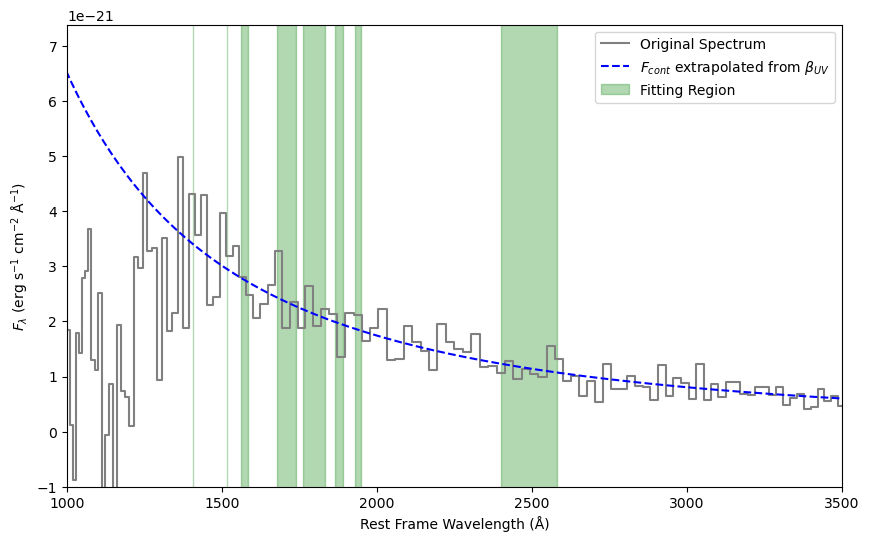

DJA_filtered_56_66/gds-udeep-v3_prism-clear_3215_201850.spec.fits | LyA Damping Parameter (D_LyA): 63.133
Processing DJA_filtered_56_66/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits with redshift z = 5.9137
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.03028485
    reduced chi-square = 0.00275317
    Akaike info crit   = -74.8067422
    Bayesian info crit = -73.6768435
    R-squared          = 0.91947774
[[Variables]]
    beta:         -2.06913082 +/- 0.18462009 (8.92%) (init = -1.5)
    log_FUV_1550: -19.9535184 +/- 0.02707783 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8433


100%|██████████| 5000/5000 [00:03<00:00, 1481.31it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


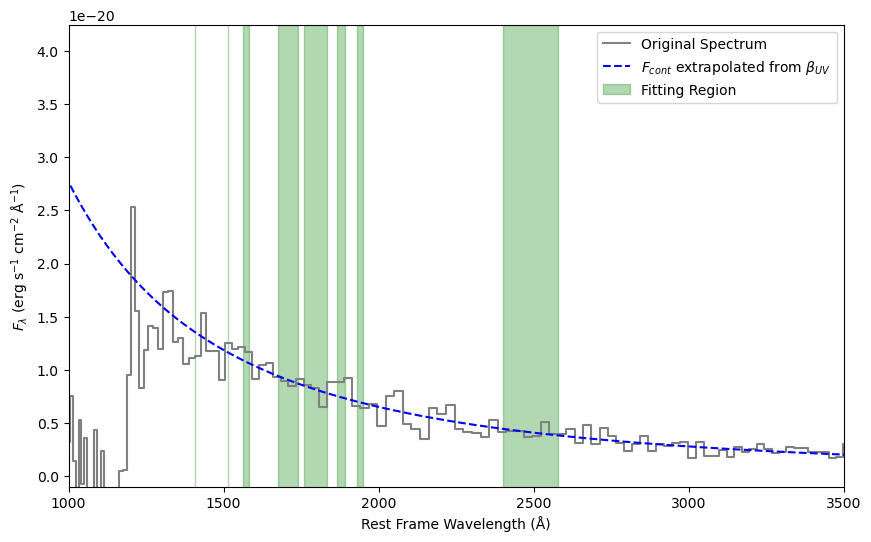

DJA_filtered_56_66/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits | LyA Damping Parameter (D_LyA): 28.351
Processing DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_14160.spec.fits with redshift z = 6.3141
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.08131914
    reduced chi-square = 0.00677660
    Akaike info crit   = -68.0780359
    Bayesian info crit = -66.7999212
    R-squared          = 0.86330288
[[Variables]]
    beta:         -2.41446617 +/- 0.27735026 (11.49%) (init = -1.5)
    log_FUV_1550: -19.9719776 +/- 0.04226711 (0.21%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8538


100%|██████████| 5000/5000 [00:03<00:00, 1508.77it/s]


β_UV: -2.40 with 16-84 percentile range: [-2.40, -2.40]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


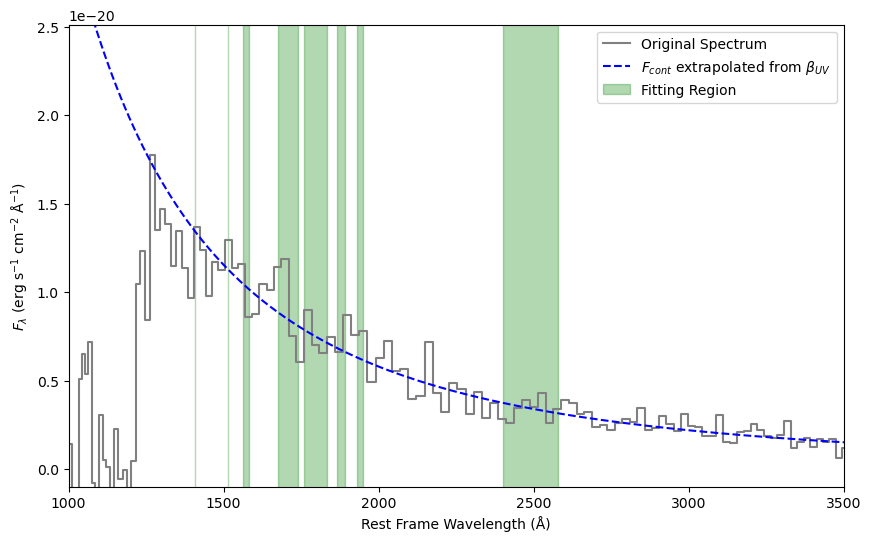

DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_14160.spec.fits | LyA Damping Parameter (D_LyA): 66.666
Processing DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits with redshift z = 5.9172
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.12293118
    reduced chi-square = 0.01117556
    Akaike info crit   = -56.5940395
    Bayesian info crit = -55.4641408
    R-squared          = 0.79121717
[[Variables]]
    beta:         -2.40156356 +/- 0.37196089 (15.49%) (init = -1.5)
    log_FUV_1550: -19.8582514 +/- 0.05448578 (0.27%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8429


100%|██████████| 5000/5000 [00:03<00:00, 1506.66it/s]


β_UV: -2.45 with 16-84 percentile range: [-2.45, -2.45]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


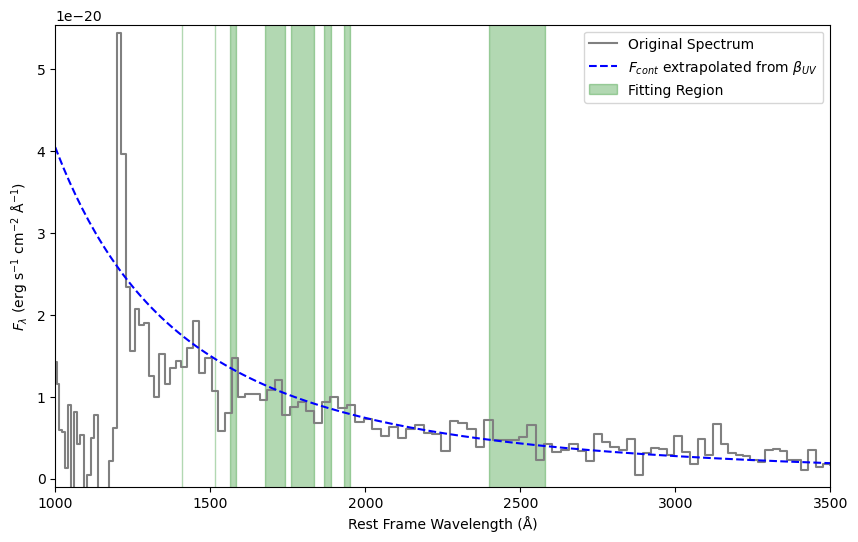

DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits | LyA Damping Parameter (D_LyA): 3.801
Processing DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_9696.spec.fits with redshift z = 5.8627
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.54884468
    reduced chi-square = 0.04573706
    Akaike info crit   = -41.3459598
    Bayesian info crit = -40.0678451
    R-squared          = 0.63956028
[[Variables]]
    beta:         -3.42486797 +/- 0.74221340 (21.67%) (init = -1.5)
    log_FUV_1550: -20.0631971 +/- 0.10561980 (0.53%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8409


100%|██████████| 5000/5000 [00:03<00:00, 1478.30it/s]


β_UV: -3.81 with 16-84 percentile range: [-3.81, -3.81]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


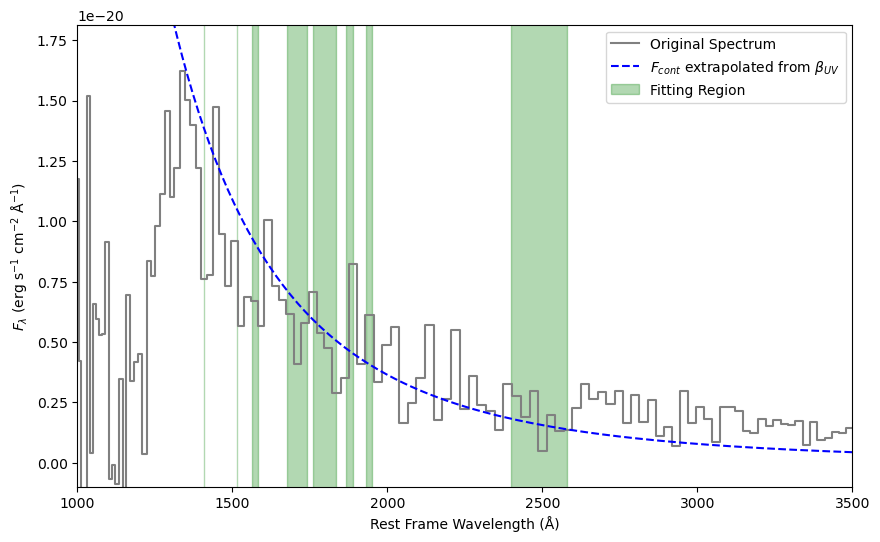

DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_9696.spec.fits | LyA Damping Parameter (D_LyA): 77.151
Processing DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_9877.spec.fits with redshift z = 6.1015
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.03097489
    reduced chi-square = 0.00258124
    Akaike info crit   = -81.5908990
    Bayesian info crit = -80.3127844
    R-squared          = 0.93467097
[[Variables]]
    beta:         -2.26030585 +/- 0.17250446 (7.63%) (init = -1.5)
    log_FUV_1550: -19.4572932 +/- 0.02621736 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:03<00:00, 1492.41it/s]


β_UV: -2.27 with 16-84 percentile range: [-2.27, -2.27]
log_FUV_1550: -1.95e+01 with 16-84 percentile range: [-1.95e+01, -1.95e+01]


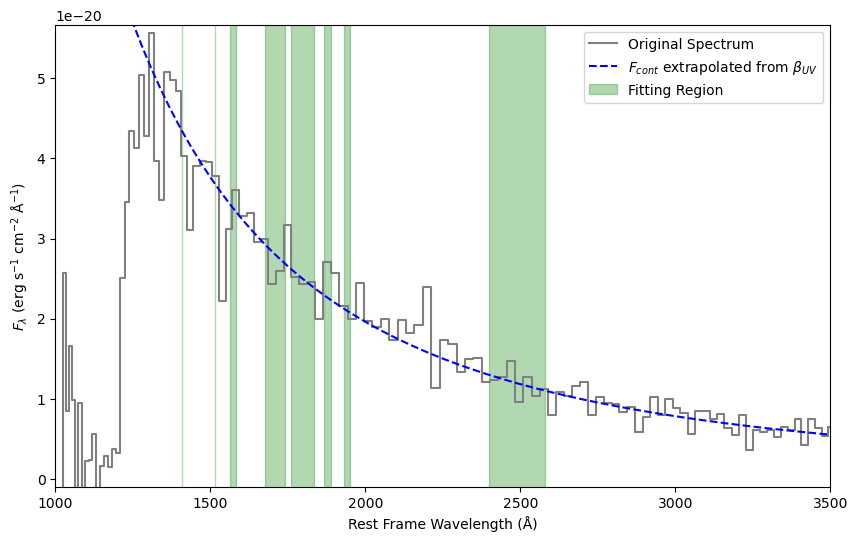

DJA_filtered_56_66/jades-gds-wide-v3_prism-clear_1180_9877.spec.fits | LyA Damping Parameter (D_LyA): 53.502

Summary of Results as Table:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
       gds-deep-v3_prism-clear_1210_5113.spec.fits ...     75.03982523904632
       gds-deep-v3_prism-clear_1210_8253.spec.fits ...      62.3636061331002
       gds-deep-v3_prism-clear_1210_9414.spec.fits ...   -31.696315059622123
       gds-deep-v3_prism-clear_1210_9423.spec.fits ...     66.59503497852586
       gds-deep-v3_prism-clear_1210_9842.spec.fits ...     65.98520016707596
       gds-deep-v3_prism-clear_1210_9867.spec.fits ...     44.90776836192703
       gds-deep-v3_prism-clear_1210_9880.spec.fits ...    0.9277449094383556
gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits ...     45.27757408379429
    gds-udeep-v3_prism-clear_3215_201127.spec.fits ...     40.74494361236984
    gds-udeep-

In [7]:
#5
results_table = process_spectra(filtered_table, folder_name=set)

In [8]:
results_table

File Name,z_spec,B_UV,LyA Damping Parameter
str50,float64,float64,float64
gds-deep-v3_prism-clear_1210_5113.spec.fits,5.8183,-2.1035578367099728,75.03982523904632
gds-deep-v3_prism-clear_1210_8253.spec.fits,6.3295,-2.7673916060225676,62.3636061331002
gds-deep-v3_prism-clear_1210_9414.spec.fits,5.8916,-2.8561258337673854,-31.696315059622123
gds-deep-v3_prism-clear_1210_9423.spec.fits,6.3346,-2.3165818819923567,66.59503497852586
gds-deep-v3_prism-clear_1210_9842.spec.fits,5.8026,-2.0918187228637497,65.98520016707596
gds-deep-v3_prism-clear_1210_9867.spec.fits,6.105,-1.5402377895353716,44.90776836192703
gds-deep-v3_prism-clear_1210_9880.spec.fits,5.9804,-2.41191137446414,0.9277449094383556
gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits,5.9324,-2.4243283430917817,45.27757408379429
gds-udeep-v3_prism-clear_3215_201127.spec.fits,5.8353,-1.752477675619223,40.74494361236984


In [9]:
#6
# Find the halfway point (50th percentile) of the Lyα damping parameter
mid_point = np.percentile(results_table['LyA Damping Parameter'], 50)


## Split the table into two based on Lyα damping parameter
damped_sources = results_table[results_table['LyA Damping Parameter'] > mid_point]
non_damped_sources = results_table[results_table['LyA Damping Parameter'] <= mid_point]

# Optionally, you can print the two tables or save them as separate files
print("Damped Sources:")
print(damped_sources)

print("\nNon-Damped Sources:")
print(non_damped_sources)


# Get the 'File Name' values from the damped_table
damped_files = damped_sources['File Name']
non_damped_files = non_damped_sources['File Name']

# Filter the original table based on the 'File Name' values
damped_sources = filtered_table[np.isin(filtered_table['file'], damped_files)]
non_damped_sources = filtered_table[np.isin(filtered_table['file'], non_damped_files)]


# Optionally save to FITS or CSV
damped_sources.write('/Users/s2537809/Downloads/damped_sources.csv', overwrite=True)
non_damped_sources.write('/Users/s2537809/Downloads/non_damped_sources.csv', overwrite=True)

Damped Sources:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
       gds-deep-v3_prism-clear_1210_5113.spec.fits ...     75.03982523904632
       gds-deep-v3_prism-clear_1210_8253.spec.fits ...      62.3636061331002
       gds-deep-v3_prism-clear_1210_9423.spec.fits ...     66.59503497852586
       gds-deep-v3_prism-clear_1210_9842.spec.fits ...     65.98520016707596
    gds-udeep-v3_prism-clear_3215_201850.spec.fits ...    63.133363748288566
jades-gds-wide-v3_prism-clear_1180_14160.spec.fits ...     66.66585818683231
 jades-gds-wide-v3_prism-clear_1180_9696.spec.fits ...     77.15129691815767

Non-Damped Sources:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
       gds-deep-v3_prism-clear_1210_9414.spec.fits ...   -31.696315059622123
       gds-deep-v3_prism-clear_1210_986

In [34]:
blindsources

ID,DATASET,DEPTH,FROM,ZCONF,MCONF,IFLAG,ZSYS,ZSYS_ERR,REFZ,Z_1,Z_ERR,DLYAFIT,DV_ABS,DV_ERR_ABS,DV_BALMER,DV_ERR_BALMER,DV_CIV1548,DV_ERR_CIV1548,DV_FORBIDDEN,DV_ERR_FORBIDDEN,DV_LYALPHA,DV_ERR_LYALPHA,DV_MGII2796,DV_ERR_MGII2796,RA_1,DEC_1,CENTER,IN_HST,IN_ORI,IN_DR1,IN_MXDF,IN_UDF10,RAF_ID,RAF_MIDS,CANDELS_ID,CANDELS_MIDS,3DHST_ID,3DHST_MIDS,ASTRO_ID,ASTRO_MIDS,MAG_SRC,MAG_AFLAG,MAG_F606W,MAGERR_F606W,MAG_F775W,MAGERR_F775W,MAG_F850LP,MAGERR_F850LP,MASS_PRO,LERR_MASS_PRO,HERR_MASS_PRO,MASS_MAG,LERR_MASS_MAG,HERR_MASS_MAG,SFR_PRO,LERR_SFR_PRO,HERR_SFR_PRO,SFR_MAG,LERR_SFR_MAG,HERR_SFR_MAG,LINE_SNR_MAX,SNR_MAX,FLUX_MAX,LYALPHA_EMI_FLUX,LYALPHA_EMI_SNR,LYALPHA_EMI_EQW,LYALPHA_EMI_VD,CIV1548_EMI_FLUX,CIV1548_EMI_SNR,CIV1548_EMI_EQW,CIV1548_EMI_VD,CIV1550_EMI_FLUX,CIV1550_EMI_SNR,CIV1550_EMI_EQW,CIV1550_EMI_VD,HeII1640_EMI_FLUX,HeII1640_EMI_SNR,HeII1640_EMI_EQW,HeII1640_EMI_VD,OIII1666_EMI_FLUX,OIII1666_EMI_SNR,OIII1666_EMI_EQW,OIII1666_EMI_VD,SiIII1883_EMI_FLUX,SiIII1883_EMI_SNR,SiIII1883_EMI_EQW,SiIII1883_EMI_VD,CIII1907_EMI_FLUX,CIII1907_EMI_SNR,CIII1907_EMI_EQW,CIII1907_EMI_VD,CIII1909_EMI_FLUX,CIII1909_EMI_SNR,CIII1909_EMI_EQW,CIII1909_EMI_VD,MgII2796_EMI_FLUX,MgII2796_EMI_SNR,MgII2796_EMI_EQW,MgII2796_EMI_VD,MgII2803_EMI_FLUX,MgII2803_EMI_SNR,MgII2803_EMI_EQW,MgII2803_EMI_VD,OII3726_EMI_FLUX,OII3726_EMI_SNR,OII3726_EMI_EQW,OII3726_EMI_VD,OII3729_EMI_FLUX,OII3729_EMI_SNR,OII3729_EMI_EQW,OII3729_EMI_VD,H11_EMI_FLUX,H11_EMI_SNR,H11_EMI_EQW,H11_EMI_VD,H10_EMI_FLUX,H10_EMI_SNR,H10_EMI_EQW,H10_EMI_VD,H9_EMI_FLUX,H9_EMI_SNR,H9_EMI_EQW,H9_EMI_VD,NeIII3869_EMI_FLUX,NeIII3869_EMI_SNR,NeIII3869_EMI_EQW,NeIII3869_EMI_VD,HeI3889_EMI_FLUX,HeI3889_EMI_SNR,HeI3889_EMI_EQW,HeI3889_EMI_VD,H8_EMI_FLUX,H8_EMI_SNR,H8_EMI_EQW,H8_EMI_VD,NeIII3967_EMI_FLUX,NeIII3967_EMI_SNR,NeIII3967_EMI_EQW,NeIII3967_EMI_VD,HEPSILON_EMI_FLUX,HEPSILON_EMI_SNR,HEPSILON_EMI_EQW,HEPSILON_EMI_VD,HDELTA_EMI_FLUX,HDELTA_EMI_SNR,HDELTA_EMI_EQW,HDELTA_EMI_VD,HGAMMA_EMI_FLUX,HGAMMA_EMI_SNR,HGAMMA_EMI_EQW,HGAMMA_EMI_VD,HBETA_EMI_FLUX,HBETA_EMI_SNR,HBETA_EMI_EQW,HBETA_EMI_VD,OIII4959_EMI_FLUX,OIII4959_EMI_SNR,OIII4959_EMI_EQW,OIII4959_EMI_VD,OIII5007_EMI_FLUX,OIII5007_EMI_SNR,OIII5007_EMI_EQW,OIII5007_EMI_VD,HALPHA_EMI_FLUX,HALPHA_EMI_SNR,HALPHA_EMI_EQW,HALPHA_EMI_VD,NII6584_EMI_FLUX,NII6584_EMI_SNR,NII6584_EMI_EQW,NII6584_EMI_VD,SII6717_EMI_FLUX,SII6717_EMI_SNR,SII6717_EMI_EQW,SII6717_EMI_VD,SiII1260_ABS_FLUX,SiII1260_ABS_SNR,SiII1260_ABS_EQW,SiII1260_ABS_VD,OI1302_ABS_FLUX,OI1302_ABS_SNR,OI1302_ABS_EQW,OI1302_ABS_VD,CII1334_ABS_FLUX,CII1334_ABS_SNR,CII1334_ABS_EQW,CII1334_ABS_VD,SiIV1394_ABS_FLUX,SiIV1394_ABS_SNR,SiIV1394_ABS_EQW,SiIV1394_ABS_VD,SiIV1403_ABS_FLUX,SiIV1403_ABS_SNR,SiIV1403_ABS_EQW,SiIV1403_ABS_VD,SiII1527_ABS_FLUX,SiII1527_ABS_SNR,SiII1527_ABS_EQW,SiII1527_ABS_VD,CIV1548_ABS_FLUX,CIV1548_ABS_SNR,CIV1548_ABS_EQW,CIV1548_ABS_VD,CIV1550_ABS_FLUX,CIV1550_ABS_SNR,CIV1550_ABS_EQW,CIV1550_ABS_VD,FeII1608_ABS_FLUX,FeII1608_ABS_SNR,FeII1608_ABS_EQW,FeII1608_ABS_VD,AlII1671_ABS_FLUX,AlII1671_ABS_SNR,AlII1671_ABS_EQW,AlII1671_ABS_VD,AlIII1854_ABS_FLUX,AlIII1854_ABS_SNR,AlIII1854_ABS_EQW,AlIII1854_ABS_VD,AlIII1862_ABS_FLUX,AlIII1862_ABS_SNR,AlIII1862_ABS_EQW,AlIII1862_ABS_VD,FeII2344_ABS_FLUX,FeII2344_ABS_SNR,FeII2344_ABS_EQW,FeII2344_ABS_VD,FeII2374_ABS_FLUX,FeII2374_ABS_SNR,FeII2374_ABS_EQW,FeII2374_ABS_VD,FeII2382_ABS_FLUX,FeII2382_ABS_SNR,FeII2382_ABS_EQW,FeII2382_ABS_VD,FeII2586_ABS_FLUX,FeII2586_ABS_SNR,FeII2586_ABS_EQW,FeII2586_ABS_VD,FeII2600_ABS_FLUX,FeII2600_ABS_SNR,FeII2600_ABS_EQW,FeII2600_ABS_VD,MgII2796_ABS_FLUX,MgII2796_ABS_SNR,MgII2796_ABS_EQW,MgII2796_ABS_VD,MgII2803_ABS_FLUX,MgII2803_ABS_SNR,MgII2803_ABS_EQW,MgII2803_ABS_VD,MgI2853_ABS_FLUX,MgI2853_ABS_SNR,MgI2853_ABS_EQW,MgI2853_ABS_VD,H11_ABS_FLUX,H11_ABS_SNR,H11_ABS_EQW,H11_ABS_VD,H10_ABS_FLUX,H10_ABS_SNR,H10_ABS_EQW,H10_ABS_VD,H9_ABS_FLUX,H9_ABS_SNR,H9_ABS_EQW,H9_ABS_VD,H8_ABS_FLUX,H8_ABS_SNR,H8_ABS_EQW,H8_ABS_VD,CaK_ABS_FLUX,CaK_ABS_SNR,CaK_ABS_EQW,CaK_ABS_VD,CaH_ABS_FLUX,CaH_ABS_SNR,CaH_ABS_EQW,C

Processing file 1/7: gds-deep-v3_prism-clear_1210_9880.spec.fits
gds-deep-v3_prism-clear_1210_9880.spec.fits downloaded to DJA_filtered_56_66_matched.
Processing file 2/7: jades-gds-wide-v3_prism-clear_1180_9877.spec.fits
jades-gds-wide-v3_prism-clear_1180_9877.spec.fits downloaded to DJA_filtered_56_66_matched.
Processing file 3/7: gds-udeep-v3_prism-clear_3215_201127.spec.fits
gds-udeep-v3_prism-clear_3215_201127.spec.fits downloaded to DJA_filtered_56_66_matched.
Processing file 4/7: jades-gds-wide-v3_prism-clear_1180_9365.spec.fits
jades-gds-wide-v3_prism-clear_1180_9365.spec.fits downloaded to DJA_filtered_56_66_matched.
Processing file 5/7: gds-deep-v3_prism-clear_1210_9414.spec.fits
gds-deep-v3_prism-clear_1210_9414.spec.fits downloaded to DJA_filtered_56_66_matched.
Processing file 6/7: jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits
jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits downloaded to DJA_filtered_56_66_matched.
Processing file 7/7: gds-deep-v3_prism-clear_1210_

100%|██████████| 5000/5000 [00:02<00:00, 2163.56it/s]


β_UV: -2.41 with 16-84 percentile range: [-2.41, -2.41]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


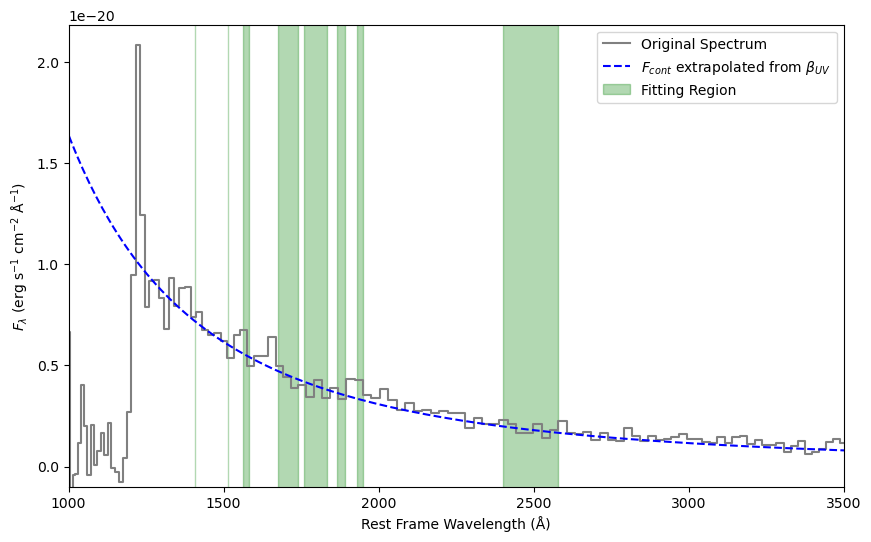

DJA_filtered_56_66_matched/gds-deep-v3_prism-clear_1210_9880.spec.fits | LyA Damping Parameter (D_LyA): 0.928
Processing DJA_filtered_56_66_matched/jades-gds-wide-v3_prism-clear_1180_9877.spec.fits with redshift z = 6.1015
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.03097489
    reduced chi-square = 0.00258124
    Akaike info crit   = -81.5908990
    Bayesian info crit = -80.3127844
    R-squared          = 0.93467097
[[Variables]]
    beta:         -2.26030585 +/- 0.17250446 (7.63%) (init = -1.5)
    log_FUV_1550: -19.4572932 +/- 0.02621736 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:02<00:00, 2110.44it/s]


β_UV: -2.27 with 16-84 percentile range: [-2.27, -2.27]
log_FUV_1550: -1.95e+01 with 16-84 percentile range: [-1.95e+01, -1.95e+01]


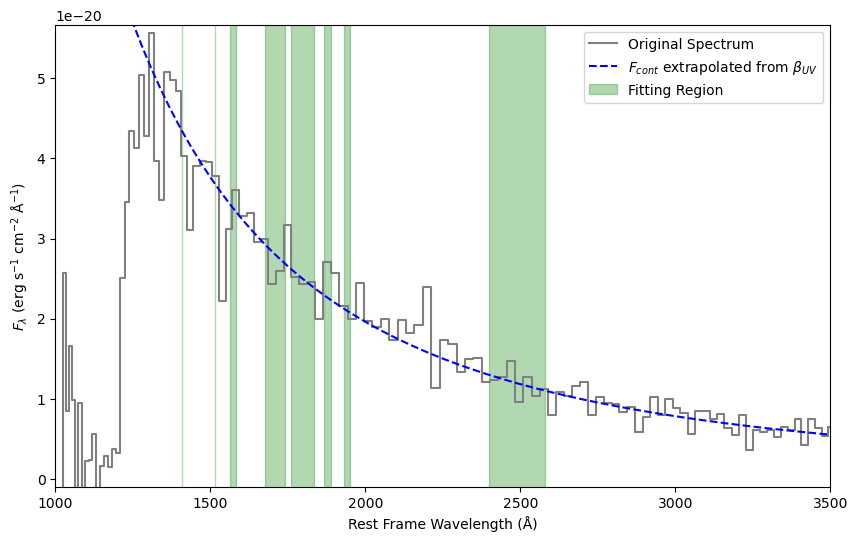

DJA_filtered_56_66_matched/jades-gds-wide-v3_prism-clear_1180_9877.spec.fits | LyA Damping Parameter (D_LyA): 53.502
Processing DJA_filtered_56_66_matched/gds-udeep-v3_prism-clear_3215_201127.spec.fits with redshift z = 5.8353
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01694847
    reduced chi-square = 0.00141237
    Akaike info crit   = -90.0328916
    Bayesian info crit = -88.7547769
    R-squared          = 0.93556487
[[Variables]]
    beta:         -1.72565902 +/- 0.13073406 (7.58%) (init = -1.5)
    log_FUV_1550: -20.1583330 +/- 0.01878332 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8450


100%|██████████| 5000/5000 [00:02<00:00, 2114.18it/s]


β_UV: -1.75 with 16-84 percentile range: [-1.75, -1.75]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


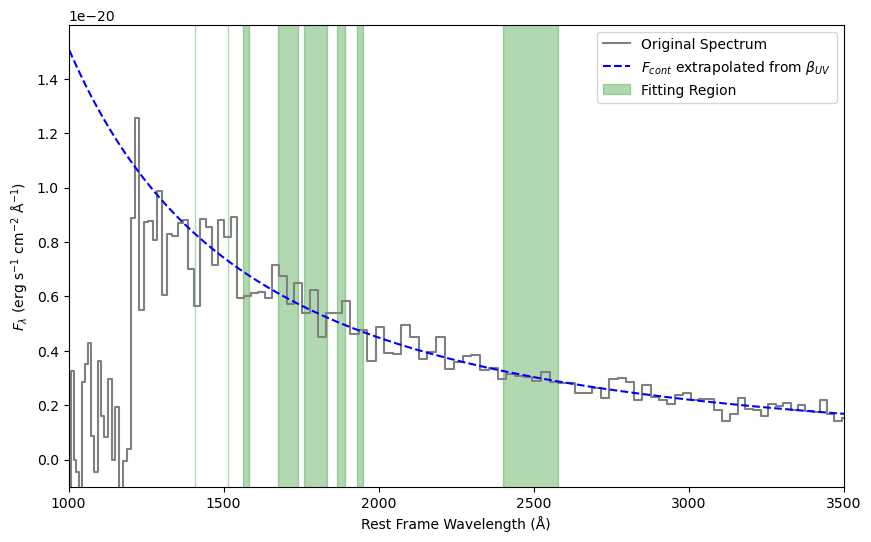

DJA_filtered_56_66_matched/gds-udeep-v3_prism-clear_3215_201127.spec.fits | LyA Damping Parameter (D_LyA): 40.745
Processing DJA_filtered_56_66_matched/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits with redshift z = 5.9172
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.12293118
    reduced chi-square = 0.01117556
    Akaike info crit   = -56.5940395
    Bayesian info crit = -55.4641408
    R-squared          = 0.79121717
[[Variables]]
    beta:         -2.40156356 +/- 0.37196089 (15.49%) (init = -1.5)
    log_FUV_1550: -19.8582514 +/- 0.05448578 (0.27%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8429


100%|██████████| 5000/5000 [00:02<00:00, 1946.24it/s]


β_UV: -2.45 with 16-84 percentile range: [-2.45, -2.45]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


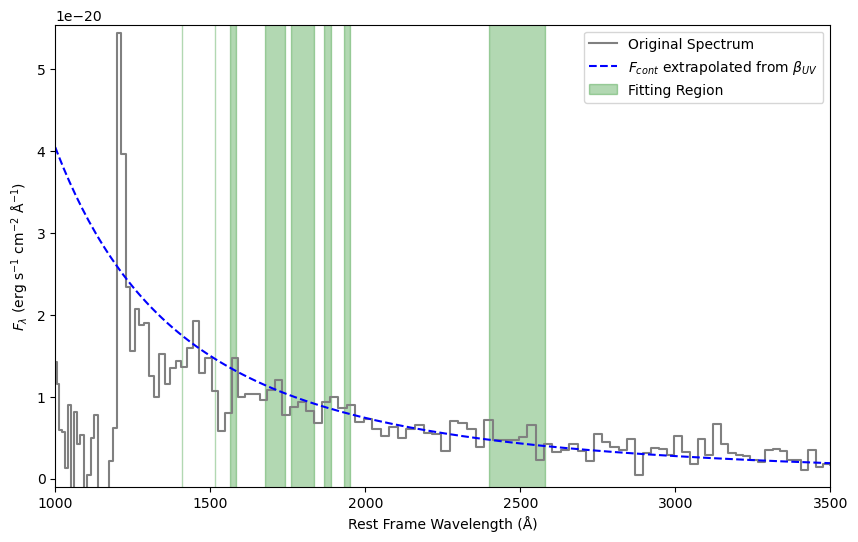

DJA_filtered_56_66_matched/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits | LyA Damping Parameter (D_LyA): 3.801
Processing DJA_filtered_56_66_matched/gds-deep-v3_prism-clear_1210_9414.spec.fits with redshift z = 5.8916
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.08733324
    reduced chi-square = 0.00623809
    Akaike info crit   = -79.3698056
    Bayesian info crit = -77.8246282
    R-squared          = 0.89665832
[[Variables]]
    beta:         -2.81828982 +/- 0.25570894 (9.07%) (init = -1.5)
    log_FUV_1550: -20.2289758 +/- 0.03677656 (0.18%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8436


100%|██████████| 5000/5000 [00:02<00:00, 1873.02it/s]


β_UV: -2.86 with 16-84 percentile range: [-2.86, -2.86]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


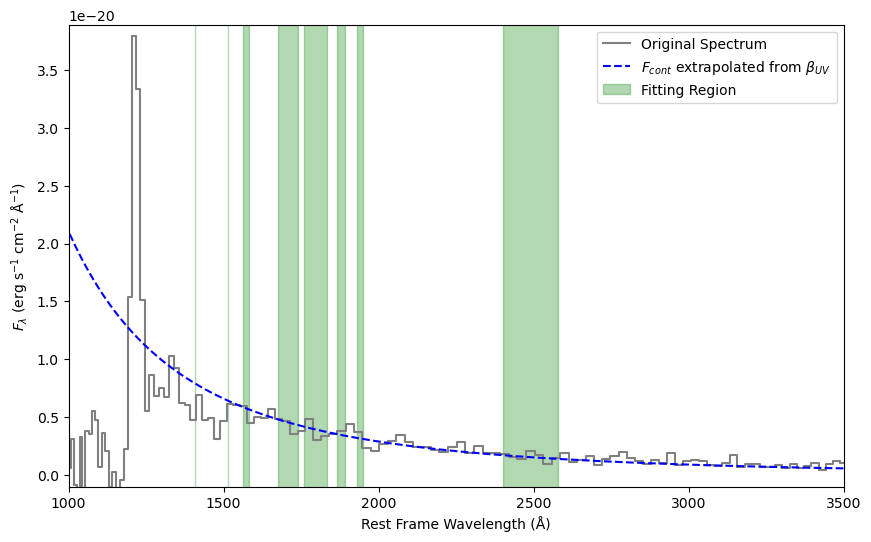

DJA_filtered_56_66_matched/gds-deep-v3_prism-clear_1210_9414.spec.fits | LyA Damping Parameter (D_LyA): -31.696
Processing DJA_filtered_56_66_matched/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits with redshift z = 5.9137
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.03028485
    reduced chi-square = 0.00275317
    Akaike info crit   = -74.8067422
    Bayesian info crit = -73.6768435
    R-squared          = 0.91947774
[[Variables]]
    beta:         -2.06913082 +/- 0.18462009 (8.92%) (init = -1.5)
    log_FUV_1550: -19.9535184 +/- 0.02707783 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8433


100%|██████████| 5000/5000 [00:02<00:00, 1945.11it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


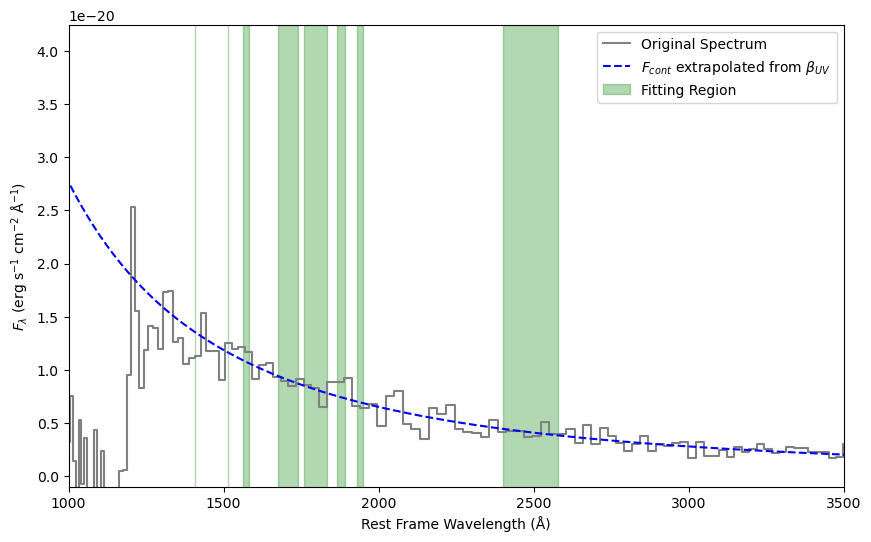

DJA_filtered_56_66_matched/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits | LyA Damping Parameter (D_LyA): 28.351
Processing DJA_filtered_56_66_matched/gds-deep-v3_prism-clear_1210_8253.spec.fits with redshift z = 6.3295
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.03686705
    reduced chi-square = 0.00283593
    Akaike info crit   = -86.1273094
    Bayesian info crit = -84.7112090
    R-squared          = 0.94589617
[[Variables]]
    beta:         -2.69189703 +/- 0.17855788 (6.63%) (init = -1.5)
    log_FUV_1550: -20.2571175 +/- 0.02654959 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:02<00:00, 1945.29it/s]


β_UV: -2.77 with 16-84 percentile range: [-2.77, -2.77]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


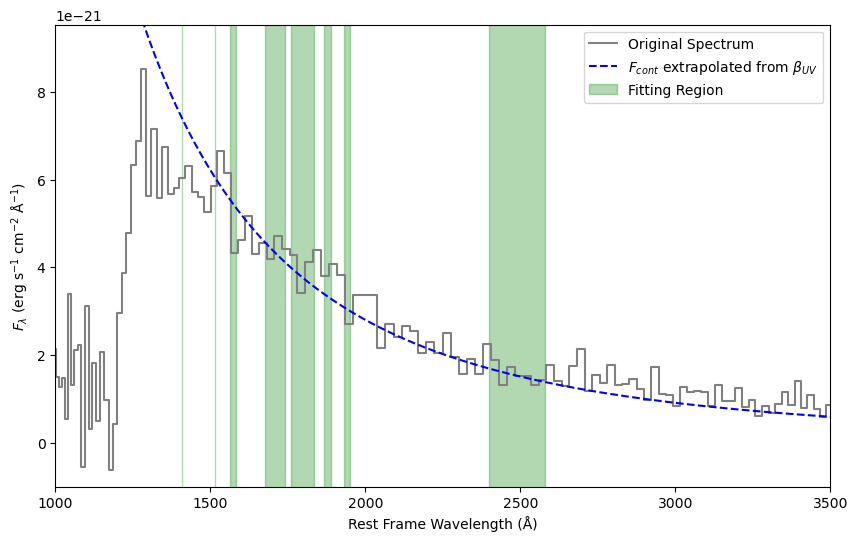

DJA_filtered_56_66_matched/gds-deep-v3_prism-clear_1210_8253.spec.fits | LyA Damping Parameter (D_LyA): 62.364

Summary of Results as Table:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
       gds-deep-v3_prism-clear_1210_9880.spec.fits ...    0.9277441976656395
 jades-gds-wide-v3_prism-clear_1180_9877.spec.fits ...     53.50243256218204
    gds-udeep-v3_prism-clear_3215_201127.spec.fits ...      40.7449426574075
 jades-gds-wide-v3_prism-clear_1180_9365.spec.fits ...     3.800612358273952
       gds-deep-v3_prism-clear_1210_9414.spec.fits ...   -31.696314065083396
jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits ...    28.351266728452643
       gds-deep-v3_prism-clear_1210_8253.spec.fits ...    62.363606478069094


In [38]:
#7

# open /Users/s2537809/Downloads/blindmuse5066.csv
matchedsources = Table.read('/Users/s2537809/Downloads/matched5666.csv', format='csv')


# change column name z_2 to z
matchedsources.rename_column('z_2', 'z')
matchedsources


set = 'DJA_filtered_56_66_matched'

download_fits_from_DJA('/Users/s2537809/Downloads/matched5666.csv', folder_name=set) 

filtered_table = filter_incomplete_spectra(filtered_sources, folder_name=set, min_wavelength=1.0, max_wavelength=4.0,target_wavelength= 1450, SNR_threshold=5.0)
filtered_table.write(f'/Users/s2537809/Downloads/{set}_table.csv', format='csv', overwrite=True)
results_table = process_spectra(matchedsources, folder_name=f'{set}')

Processing file 1/7: gds-deep-v3_prism-clear_1210_9880.spec.fits
gds-deep-v3_prism-clear_1210_9880.spec.fits already exists in DJA_filtered_56_66_blind. No need to download.
Processing file 2/7: jades-gds-wide-v3_prism-clear_1180_9877.spec.fits
jades-gds-wide-v3_prism-clear_1180_9877.spec.fits already exists in DJA_filtered_56_66_blind. No need to download.
Processing file 3/7: gds-udeep-v3_prism-clear_3215_201127.spec.fits
gds-udeep-v3_prism-clear_3215_201127.spec.fits already exists in DJA_filtered_56_66_blind. No need to download.
Processing file 4/7: jades-gds-wide-v3_prism-clear_1180_9365.spec.fits
jades-gds-wide-v3_prism-clear_1180_9365.spec.fits already exists in DJA_filtered_56_66_blind. No need to download.
Processing file 5/7: gds-deep-v3_prism-clear_1210_9414.spec.fits
gds-deep-v3_prism-clear_1210_9414.spec.fits already exists in DJA_filtered_56_66_blind. No need to download.
Processing file 6/7: jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits
jades-gds-wide2-v3_prism-cle

Processing DJA_filtered_56_66_blind/gds-udeep-v3_prism-clear_3215_201127.spec.fits with redshift z = 5.8353
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01694847
    reduced chi-square = 0.00141237
    Akaike info crit   = -90.0328916
    Bayesian info crit = -88.7547769
    R-squared          = 0.93556487
[[Variables]]
    beta:         -1.72565902 +/- 0.13073406 (7.58%) (init = -1.5)
    log_FUV_1550: -20.1583330 +/- 0.01878332 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8450


100%|██████████| 5000/5000 [00:02<00:00, 2109.65it/s]


β_UV: -1.75 with 16-84 percentile range: [-1.75, -1.75]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


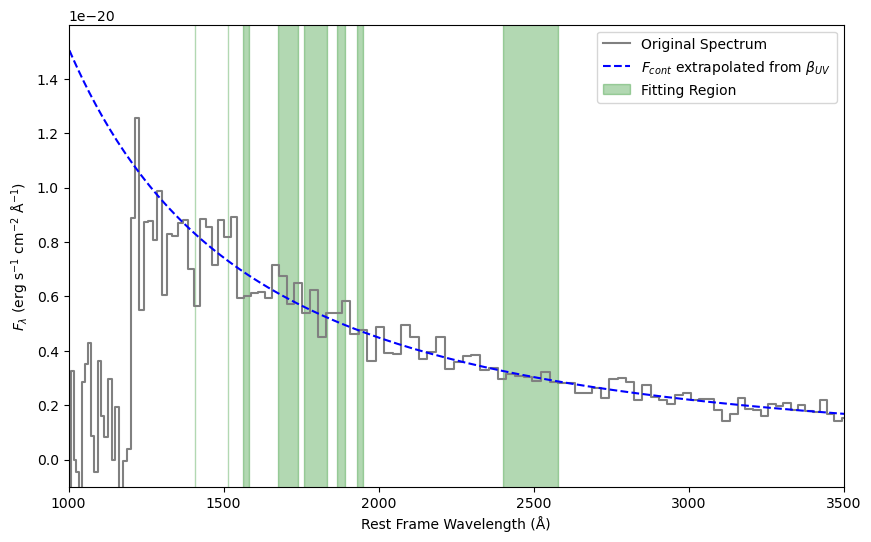

/Users/s2537809/MUSE/NIRSpec.py:327: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  DLyA = simps(integrand, wavelength_LyA)


DJA_filtered_56_66_blind/gds-udeep-v3_prism-clear_3215_201127.spec.fits | LyA Damping Parameter (D_LyA): 40.745
Processing DJA_filtered_56_66_blind/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits with redshift z = 5.9172
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.12293118
    reduced chi-square = 0.01117556
    Akaike info crit   = -56.5940395
    Bayesian info crit = -55.4641408
    R-squared          = 0.79121717
[[Variables]]
    beta:         -2.40156356 +/- 0.37196089 (15.49%) (init = -1.5)
    log_FUV_1550: -19.8582514 +/- 0.05448578 (0.27%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8429


100%|██████████| 5000/5000 [00:02<00:00, 2075.23it/s]


β_UV: -2.45 with 16-84 percentile range: [-2.45, -2.45]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


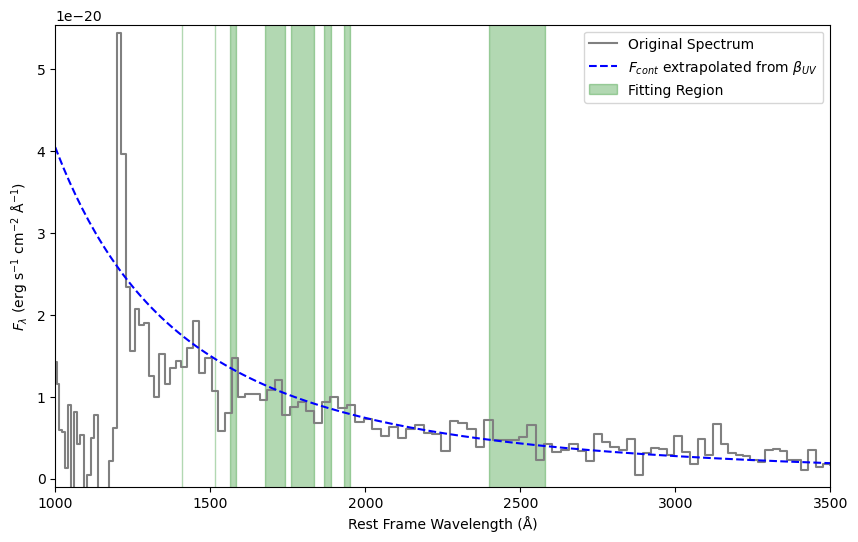

DJA_filtered_56_66_blind/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits | LyA Damping Parameter (D_LyA): 3.801
Processing DJA_filtered_56_66_blind/gds-deep-v3_prism-clear_1210_9414.spec.fits with redshift z = 5.8916
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.08733324
    reduced chi-square = 0.00623809
    Akaike info crit   = -79.3698056
    Bayesian info crit = -77.8246282
    R-squared          = 0.89665832
[[Variables]]
    beta:         -2.81828982 +/- 0.25570894 (9.07%) (init = -1.5)
    log_FUV_1550: -20.2289758 +/- 0.03677656 (0.18%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8436


100%|██████████| 5000/5000 [00:02<00:00, 1933.58it/s]


β_UV: -2.86 with 16-84 percentile range: [-2.86, -2.86]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


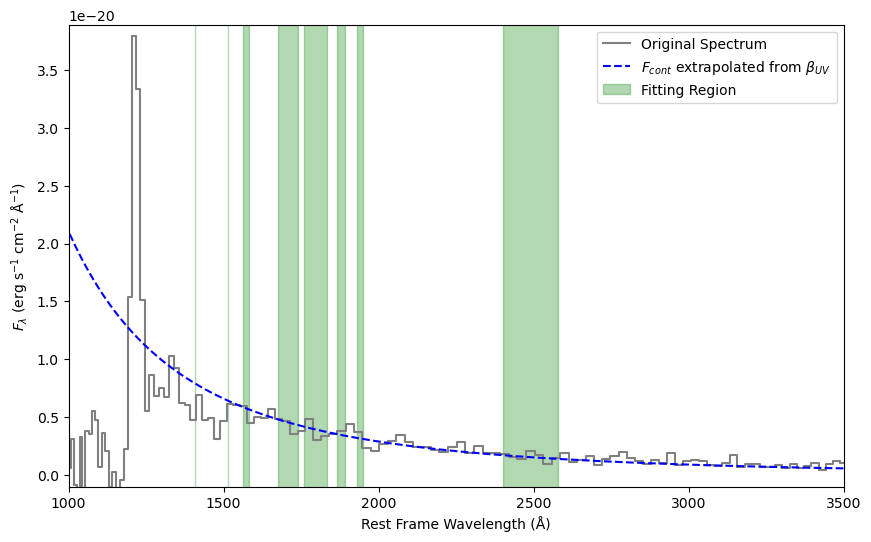

DJA_filtered_56_66_blind/gds-deep-v3_prism-clear_1210_9414.spec.fits | LyA Damping Parameter (D_LyA): -31.696
Processing DJA_filtered_56_66_blind/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits with redshift z = 5.9137
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.03028485
    reduced chi-square = 0.00275317
    Akaike info crit   = -74.8067422
    Bayesian info crit = -73.6768435
    R-squared          = 0.91947774
[[Variables]]
    beta:         -2.06913082 +/- 0.18462009 (8.92%) (init = -1.5)
    log_FUV_1550: -19.9535184 +/- 0.02707783 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8433


100%|██████████| 5000/5000 [00:02<00:00, 1919.82it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


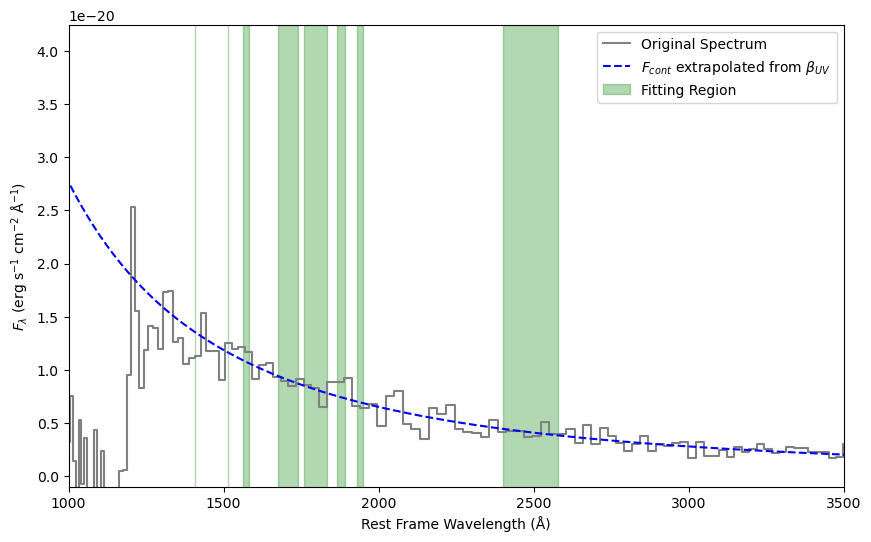

DJA_filtered_56_66_blind/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits | LyA Damping Parameter (D_LyA): 28.351
Processing DJA_filtered_56_66_blind/gds-deep-v3_prism-clear_1210_8253.spec.fits with redshift z = 6.3295
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.03686705
    reduced chi-square = 0.00283593
    Akaike info crit   = -86.1273094
    Bayesian info crit = -84.7112090
    R-squared          = 0.94589617
[[Variables]]
    beta:         -2.69189703 +/- 0.17855788 (6.63%) (init = -1.5)
    log_FUV_1550: -20.2571175 +/- 0.02654959 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:02<00:00, 1934.36it/s]


β_UV: -2.77 with 16-84 percentile range: [-2.77, -2.77]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


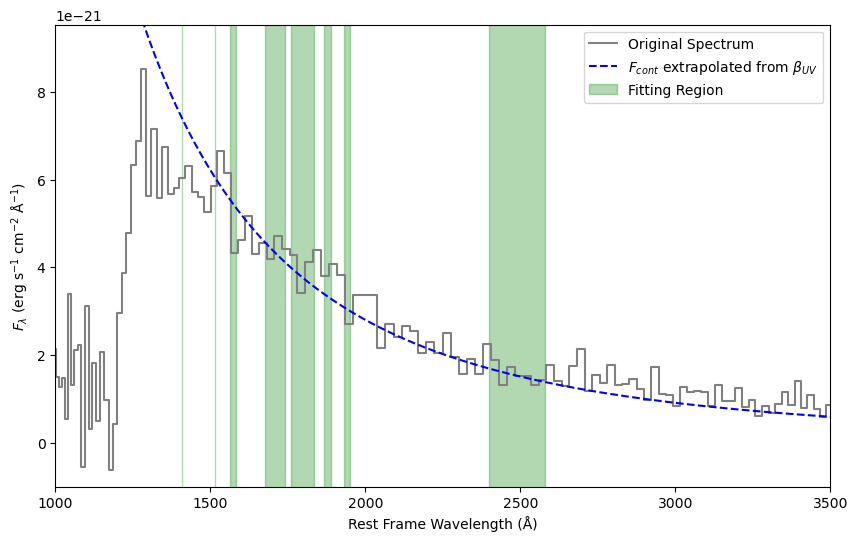

DJA_filtered_56_66_blind/gds-deep-v3_prism-clear_1210_8253.spec.fits | LyA Damping Parameter (D_LyA): 62.364

Summary of Results as Table:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
    gds-udeep-v3_prism-clear_3215_201127.spec.fits ...    40.744942923730264
 jades-gds-wide-v3_prism-clear_1180_9365.spec.fits ...    3.8006131802802514
       gds-deep-v3_prism-clear_1210_9414.spec.fits ...   -31.696315765373818
jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits ...    28.351267171175785
       gds-deep-v3_prism-clear_1210_8253.spec.fits ...     62.36360621421387


In [39]:

blindsources = matchedsources[matchedsources['FROM'] == 'ORIGIN']

set = 'DJA_filtered_56_66_blind'

download_fits_from_DJA('/Users/s2537809/Downloads/matched5666.csv', folder_name=set) 

filtered_table = filter_incomplete_spectra(blindsources, folder_name=set, min_wavelength=1.0, max_wavelength=4.0,target_wavelength= 1450, SNR_threshold=5.0)
filtered_table.write(f'/Users/s2537809/Downloads/{set}_table.csv', format='csv', overwrite=True)
results_table = process_spectra(blindsources, folder_name=f'{set}')


In [254]:
# Find the halfway point (50th percentile) of the Lyα damping parameter
mid_point = np.percentile(results_table['LyA Damping Parameter'], 50)


## Split the table into two based on Lyα damping parameter
damped_sources = results_table[results_table['LyA Damping Parameter'] > mid_point]
non_damped_sources = results_table[results_table['LyA Damping Parameter'] <= mid_point]

# Optionally, you can print the two tables or save them as separate files
print("Damped Sources:")
print(damped_sources)

print("\nNon-Damped Sources:")
print(non_damped_sources)


# Get the 'File Name' values from the damped_table
damped_files = damped_sources['File Name']
non_damped_files = non_damped_sources['File Name']

# Filter the original table based on the 'File Name' values
damped_sources = filtered_table[np.isin(filtered_table['file'], damped_files)]
non_damped_sources = filtered_table[np.isin(filtered_table['file'], non_damped_files)]


# Optionally save to FITS or CSV
damped_sources.write('/Users/s2537809/Downloads/damped_sources.csv', overwrite=True)
non_damped_sources.write('/Users/s2537809/Downloads/non_damped_sources.csv', overwrite=True)

Damped Sources:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
       gds-deep-v3_prism-clear_1210_5113.spec.fits ...     75.03982605090616
       gds-deep-v3_prism-clear_1210_9423.spec.fits ...     66.59503512860061
       gds-deep-v3_prism-clear_1210_9842.spec.fits ...     65.98519967358206
gds-egami-ddt-v3_prism-clear_6541_205434.spec.fits ...     91.01829460677692
jades-gds-wide-v3_prism-clear_1180_14160.spec.fits ...     66.66585815652064
 jades-gds-wide-v3_prism-clear_1180_9696.spec.fits ...     77.15129670909266

Non-Damped Sources:
                    File Name                      ... LyA Damping Parameter
-------------------------------------------------- ... ---------------------
      gds-deep-v3_prism-clear_1210_13577.spec.fits ...     52.28331910896325
       gds-deep-v3_prism-clear_1210_9867.spec.fits ...     44.90776899744242
gds-egami-ddt-v3_prism-clear_6541_11461

In [35]:
print(np.min(results_table['B_UV']), np.max(results_table['B_UV']))

-3.8113854096086572 -1.5402377942314143


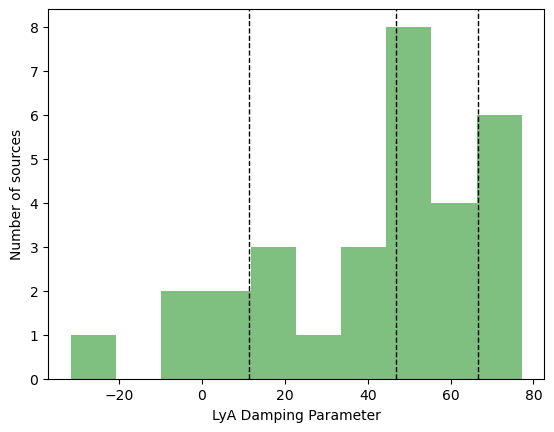

In [38]:
# plot histogram of lya damping parameter
plt.hist(results_table['LyA Damping Parameter'], bins=10, color='green', alpha=0.5)
plt.xlabel('LyA Damping Parameter')
plt.ylabel('Number of sources')
# plot vertical lines at percentiles 16, 50 and 84
plt.axvline(np.percentile(results_table['LyA Damping Parameter'], 16), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(results_table['LyA Damping Parameter'], 50), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(results_table['LyA Damping Parameter'], 84), color='black', linestyle='dashed', linewidth=1)

